In [4]:
from arch import *

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam



In [10]:
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [28]:

train_dataset = ZeroShotDataset(
    csv_path="train_split.csv", 
    img_dir="sourya-drive-import-20250803-014542/BTZSD_Dataset", 
    transform=image_transforms,
    use_description=True
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [31]:


# from open_clip import create_model_from_pretrained, get_tokenizer


# # The error indicates that the key "text.transformer.embeddings.position_ids" is missing in the state_dict.
# # This suggests that the model's state_dict might not be compatible with the current architecture.
# # To fix this, we can try to load the state_dict with strict=False, which allows missing keys.

# # Attempting to load the model with strict=False
# try:
#     detector = ZeroShotObjectDetector().to('cuda' if torch.cuda.is_available() else 'cpu')
#     # Load the state_dict with strict=False to allow missing keys
#     state_dict = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')[0]
#     # Check if the missing key is present in the state_dict
#     if "text.transformer.embeddings.position_ids" not in state_dict:
#         print("Warning: 'text.transformer.embeddings.position_ids' is missing in the state_dict.")
#     detector.load_state_dict(state_dict, strict=False)
# except RuntimeError as e:
#     print(f"RuntimeError: {e}")
#     detector = None  # Ensure detector is defined even if loading fails

# if detector is not None:
#     loss_fn = SymmetricalCrossEntropyLoss()
#     optimizer = Adam(
#         list(detector.text_projection.parameters()) + list(detector.image_projection.parameters()),
#         lr=1e-4,
#         weight_decay=1e-5
#     )
# else:
#     print("Detector could not be initialized due to missing keys in state_dict.")
from open_clip import create_model_from_pretrained, get_tokenizer

# Create the model (this returns model, preprocess, tokenizer)
try:
    model, _ = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

    detector = ZeroShotObjectDetector().to('cuda' if torch.cuda.is_available() else 'cpu')

    # If you *must* load the model's weights into your own model, extract the state dict from the model
    state_dict = model.state_dict()

    if "text.transformer.embeddings.position_ids" not in state_dict:
        print("Warning: 'text.transformer.embeddings.position_ids' is missing in the state_dict.")

    detector.load_state_dict(state_dict, strict=False)

except RuntimeError as e:
    print(f"RuntimeError: {e}")
    detector = None  # Ensure detector is defined even if loading fails

if detector is not None:
    loss_fn = SymmetricalCrossEntropyLoss()
    optimizer = Adam(
        list(detector.text_projection.parameters()) + list(detector.image_projection.parameters()),
        lr=1e-4,
        weight_decay=1e-5
    )
else:
    print("Detector could not be initialized due to missing keys in state_dict.")


/root/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading BiomedCLIP...
Loading CLIP ViT-base...


In [34]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-05
)


In [37]:
val_dataset = ZeroShotDataset("val_split.csv", "sourya-drive-import-20250803-014542/BTZSD_Dataset", transform=image_transforms)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [40]:

# def train_detector(detector, dataloader, loss_fn, optimizer, epochs=10):
#     detector.train()

#     for epoch in range(epochs):
#         total_loss = 0

#         for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
#             images = batch['image'].to(detector.device)
#             texts = batch['text_prompt']
            
#             # Encode all texts (batched)
#             text_embeddings = detector.encode_text(texts)
            
#             # Encode image patches for each image and average them
#             image_embeddings = []
#             for img in images:
#                 patch_embeds, _ = detector.encode_image_patches(img)
#                 if patch_embeds.shape[0] == 0:
#                     image_embeddings.append(torch.zeros((512,), device=detector.device))
#                 else:
#                     image_embeddings.append(patch_embeds.mean(dim=0))
#             image_embeddings = torch.stack(image_embeddings)

#             # Compute alignment loss
#             loss = loss_fn(image_embeddings, text_embeddings)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(dataloader)
#         print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")

def train_detector(detector, train_loader, val_loader, loss_fn, optimizer, epochs=1):
    for epoch in range(epochs):
        ### ---- TRAINING ----
        detector.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}"):
            images = batch['image'].to(detector.device)
            texts = batch['text_prompt']
            
            # Encode all texts (batched)
            text_embeddings = detector.encode_text(texts)
            
            # Encode image patches and average
            image_embeddings = []
            for img in images:
                patch_embeds, _ = detector.encode_image_patches(img)
                if patch_embeds.shape[0] == 0:
                    image_embeddings.append(torch.zeros((512,), device=detector.device))
                else:
                    image_embeddings.append(patch_embeds.mean(dim=0))
            image_embeddings = torch.stack(image_embeddings)

            # Compute loss
            loss = loss_fn(image_embeddings, text_embeddings)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

        ### ---- VALIDATION ----
        detector.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{epochs}"):
                images = batch['image'].to(detector.device)
                texts = batch['text_prompt']
                
                text_embeddings = detector.encode_text(texts)

                image_embeddings = []
                for img in images:
                    patch_embeds, _ = detector.encode_image_patches(img)
                    if patch_embeds.shape[0] == 0:
                        image_embeddings.append(torch.zeros((512,), device=detector.device))
                    else:
                        image_embeddings.append(patch_embeds.mean(dim=0))
                image_embeddings = torch.stack(image_embeddings)

                loss = loss_fn(image_embeddings, text_embeddings)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Avg Val Loss = {avg_val_loss:.4f}")
        print("-" * 50)


In [43]:
train_detector(detector, train_loader, val_loader, loss_fn, optimizer, epochs = 3)  

Train Epoch 1/3:   0%|          | 0/300 [00:00<?, ?it/s]/root/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Train Epoch 1/3:  67%|██████▋   | 200/300 [11:42<05:51,  3.51s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'sourya-drive-import-20250803-014542/BTZSD_Dataset/10044.jpg'

In [12]:
# val_dataset = ZeroShotDataset("finalized_reports.csv", "sourya-drive-import-20250803-014542/BTZSD_Dataset", transform=image_transforms)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

metrics = evaluate_detector(detector, val_loader)
print(f"Evaluation metrics: {metrics}")

Evaluating: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]Evaluation metrics: {'AP@IoU=0.5': 0.0}



In [13]:
import torch.nn.functional as F

def zero_shot_detect(detector, image_tensor, text_descriptions, threshold=0.3, top_k=5):
    """
    Run zero-shot detection on a single image.

    Args:
        detector: Your model
        image_tensor: Torch tensor of shape (3, H, W)
        text_descriptions: List of radiology descriptions (str)
        threshold: Minimum cosine similarity to keep a detection
        top_k: Max number of detections to return per description

    Returns:
        List of dicts with keys: 'bbox', 'score', 'description'
    """

    detector.eval()
    with torch.no_grad():
        # Move to device
        image_tensor = image_tensor.to(detector.device).unsqueeze(0)  # (1, 3, H, W)

        # Encode text descriptions
        text_embeddings = detector.encode_text(text_descriptions)  # (N_texts, D)

        # Get image region embeddings + their bounding boxes
        patch_embeds, bboxes = detector.encode_image_patches(image_tensor[0])  # (N_regions, D), (N_regions, 4)

        if patch_embeds.shape[0] == 0:
            return []

        # Normalize embeddings
        patch_embeds = F.normalize(patch_embeds, dim=-1)
        text_embeddings = F.normalize(text_embeddings, dim=-1)

        # Compute similarity: (N_regions, N_texts)
        sim_matrix = patch_embeds @ text_embeddings.T

        # For each text prompt, get top-k high scoring patches
        detections = []
        for text_idx, text in enumerate(text_descriptions):
            sims = sim_matrix[:, text_idx]  # (N_regions,)
            top_scores, top_indices = torch.topk(sims, k=min(top_k, sims.size(0)))

            for score, idx in zip(top_scores, top_indices):
                if score.item() >= threshold:
                    detections.append({
                        "bbox": bboxes[idx],     # [x_min, y_min, x_max, y_max]
                        "score": score.item(),
                        "description": text
                    })

    return detections


In [14]:
def draw_detections(image_path, detections):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for det in detections:
        bbox = det['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 5,
                f"{det['description']} ({det['score']:.2f})",
                color='red', fontsize=8, backgroundcolor='white')
    plt.axis('off')
    plt.show()

In [15]:
def preprocess_image(image_path, image_size=224):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # for CLIP-style models
    ])
    return transform(image)

In [18]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/root/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


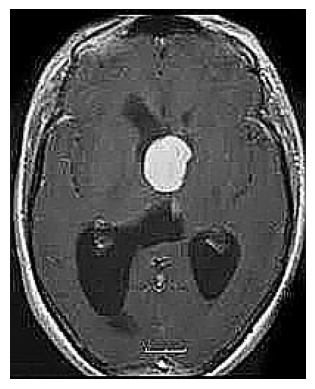

In [27]:
# === Setup ===
image_path = "sourya-drive-import-20250803-014542/BTZSD_Dataset/10753.jpg"

# Use just the radiology description as the guidance text
descriptions = [
    "A heterogeneously enhancing mass is visualized in the vicinity of the lesion center at approximately (133.394965, 178.48194999999998). The lesion measures approximately 0.83 cm in greatest dimension. It demonstrates an irregular shape with poorly defined margins. There is associated mild surrounding vasogenic edema, with subtle effacement of adjacent sulci. No evidence of midline shift or hydrocephalus is seen. No calcifications or hemorrhagic components identified."
]

# === Preprocess the image ===
image_tensor = preprocess_image(image_path)  # This must match your model input size and norm

# === Run zero-shot detection ===
detections = zero_shot_detect(
    detector=detector,
    image_tensor=image_tensor,
    text_descriptions=descriptions,
    threshold=0.3,
    top_k=5
)

# === Visualize the result ===
draw_detections(image_path, detections)



In [30]:
from tqdm import tqdm

def find_images_with_no_detections(detector, val_dataset, threshold=0.3, top_k=5):
    no_detection_images = []

    for sample in tqdm(val_dataset, desc="Scanning for empty detections"):
        # Handle tuple format (e.g., (image_tensor, label))
        if isinstance(sample, tuple):
            image_tensor = sample[0]
            text_prompt = "tumor"  # fallback prompt if none given
            image_id = "unknown"
        elif isinstance(sample, dict):
            image_tensor = sample['image']
            text_prompt = sample.get('text_prompt', 'tumor')
            image_id = sample.get('image_id', 'unknown')
        else:
            continue

        if not isinstance(image_tensor, torch.Tensor):
            continue

        image_tensor = image_tensor.to(detector.device)

        detections = zero_shot_detect(
            detector=detector,
            image_tensor=image_tensor,
            text_descriptions=[text_prompt],
            threshold=threshold,
            top_k=top_k
        )

        if len(detections) == 0:
            no_detection_images.append(image_id)

    return no_detection_images

In [33]:
# Suppose val_dataset is your validation dataset (e.g., a torch.utils.data.Dataset)
no_hits = find_images_with_no_detections(detector, train_dataset)

print("Images with NO detections:")
for img_id in no_hits:
    print(img_id)


Scanning for empty detections: 100%|██████████| 80/80 [00:36<00:00,  2.20it/s]Images with NO detections:
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown



In [21]:
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T

# === Paths ===
csv_path = "finalized_reports.csv"
image_folder = "sourya-drive-import-20250803-014542/BTZSD_Dataset"

# === Transform (Adjust if needed) ===
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# === IoU Function ===
def box_iou(boxA, boxB):
    boxA = torch.tensor(boxA)
    boxB = torch.tensor(boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)

    return iou

# === Load CSV ===
df = pd.read_csv(csv_path)

# === Run Through Each Image ===
for i, row in tqdm(df.iterrows(), total=len(df), desc="Searching for good image"):
    cond = False
    image_id = row['image_id']
    image_path = os.path.join(image_folder, image_id)

    if not os.path.exists(image_path):
        continue

    try:
        image = Image.open(image_path).convert("RGB")
    except:
        continue

    gt_box = [
        float(row['x_min']),
        float(row['y_min']),
        float(row['x_max']),
        float(row['y_max'])
    ]
    prompt = row['description']

    # Preprocess and run detection
    image_tensor = transform(image).unsqueeze(0).to(detector.device)

    try:
        pred_boxes = zero_shot_detect(detector, image_tensor, [prompt])
    except Exception as e:
        print(f"Error on {image_id}: {e}")
        continue

    if pred_boxes is None or len(pred_boxes) == 0:
        continue

    # Check IoU
    for j, pred_box in enumerate(pred_boxes):
        iou = box_iou(pred_box['bbox'], gt_box)
        if iou > 0.1:
            print(f"\n✅ FOUND good prediction for: {image_id}")
            print(f"GT Box: {gt_box}")
            print(f"Pred Box: {pred_box['bbox']}, IoU: {iou:.2f}")
            cond = True
            break
    if cond:
        break

Searching for good image:   0%|          | 0/11357 [00:00<?, ?it/s]/root/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Searching for good image:   4%|▍         | 462/11357 [02:52<1:07:56,  2.67it/s]
✅ FOUND good prediction for: 10753.jpg
GT Box: [90.616264, 85.09116, 124.04672, 124.87531]
Pred Box: (96, 80, 128, 112), IoU: 0.47



In [30]:
# import torchvision
# from tqdm import tqdm

# def box_iou(boxA, boxB):
#     # box format: [xmin, ymin, xmax, ymax]
#     boxA = torch.tensor(boxA)
#     boxB = torch.tensor(boxB)

#     # Intersection
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[2], boxB[2])
#     yB = min(boxA[3], boxB[3])
#     interArea = max(0, xB - xA) * max(0, yB - yA)

#     # Union
#     boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
#     boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
#     iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)

#     return iou

# # Search for a usable image
# for i in tqdm(range(len(train_dataset))):
#     sample = train_dataset[i]
#     image = sample['image'].unsqueeze(0).to(detector.device)
#     prompt = sample['text_prompt']
#     image_id = sample.get('image_id', f"sample_{i}")
#     gt_box = sample['gt_box']  # Format: [xmin, ymin, xmax, ymax]

#     # Run detection
#     pred_boxes = zero_shot_detect(detector, image, [prompt])

#     if pred_boxes is None or len(pred_boxes) == 0:
#         continue

#     # Compare predictions to GT
#     for j, pred_box in enumerate(pred_boxes):
#         # print(pred_box)
#         iou = box_iou(pred_box['bbox'], gt_box)
#         if iou > 0.1:
#             print(f"\n✅ FOUND good prediction for: {image_id}")
#             print(f"GT Box: {gt_box}")
#             print(f"Pred Box: {pred_box.cpu().numpy()}, IoU: {iou:.2f}, Score: {scores[j]:.2f}")
#             break


In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def draw_boxes_from_file(image_path, boxes, colors=None, labels=None, title=""):
    """
    Draws boxes on the given image file with optional labels.

    Args:
        image_path (str): Path to the image file.
        boxes (list of lists or tuples): List of boxes, each in [xmin, ymin, xmax, ymax].
        colors (list of str, optional): List of box colors. Defaults to red for all.
        labels (list of str, optional): List of class labels or headers for each box.
        title (str, optional): Title of the plot.
    """
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(title)

    if colors is None:
        colors = ['red'] * len(boxes)
    if labels is None:
        labels = [f'Box {i+1}' for i in range(len(boxes))]

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        color = colors[i]

        # Draw the box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        # Draw the label as a small header above the box
        ax.text(
            xmin,
            max(ymin - 10, 0),
            labels[i],
            fontsize=10,
            color='white',
            bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

    plt.axis('off')
    plt.tight_layout()
    plt.show()


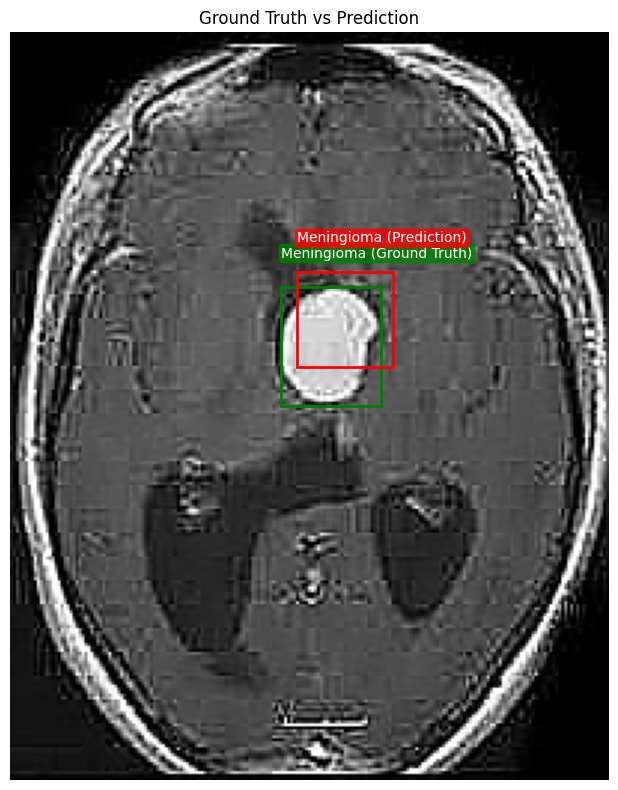

In [42]:
image_path = "sourya-drive-import-20250803-014542/BTZSD_Dataset/10753.jpg"
boxes = [
   [90.616264, 85.09116, 124.04672, 124.87531],  # Ground truth
    [96, 80, 128, 112]       # Example prediction
]
colors = ['green', 'red']
labels = ['Meningioma (Ground Truth)', 'Meningioma (Prediction)']

draw_boxes_from_file(image_path, boxes, colors, labels, title="Ground Truth vs Prediction")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=243ab71c-1ca1-4390-904b-984811a81a7a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>